**INSTALL LIBRARY**

In [1]:
!pip install pandas numpy matplotlib scikit-learn tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


**DOWNLOAD DATASET NAB**

In [3]:
!git clone https://github.com/numenta/NAB.git


Cloning into 'NAB'...
remote: Enumerating objects: 7119, done.
remote: Counting objects: 100% (731/731), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 7119 (delta 564), reused 502 (delta 502), pack-reused 6388 (from 1)
Receiving objects: 100% (7119/7119), 86.16 MiB | 21.42 MiB/s, done.
Resolving deltas: 100% (4983/4983), done.
Updating files: 100% (1186/1186), done.


In [4]:
file_path = 'NAB/data/realKnownCause/ambient_temperature_system_failure.csv'
data = pd.read_csv(file_path)
data.head()


,timestamp,value
0,2013-07-04 00:00:00,69.880835
1,2013-07-04 01:00:00,71.220227
2,2013-07-04 02:00:00,70.877805
3,2013-07-04 03:00:00,68.959400
4,2013-07-04 04:00:00,69.283551


**PRA-PEMROSESAN DATASET**

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.rename(columns={'value': 'sensor'}, inplace=True)


In [6]:
data['label'] = 0

start_anomaly = pd.to_datetime('2014-04-13 23:30:00')
end_anomaly   = pd.to_datetime('2014-04-15 01:00:00')

data.loc[
    (data['timestamp'] >= start_anomaly) &
    (data['timestamp'] <= end_anomaly),
    'label'
] = 1


**VISUALISASI DATA**

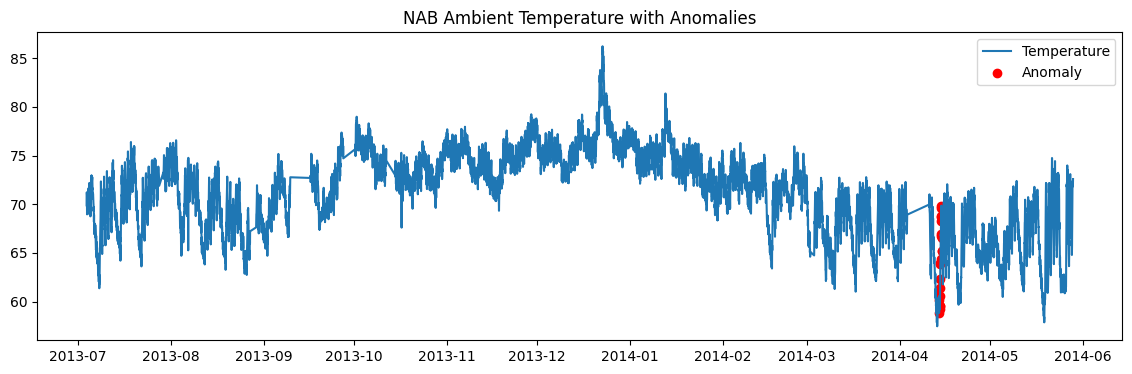

In [7]:
plt.figure(figsize=(14,4))
plt.plot(data['timestamp'], data['sensor'], label='Temperature')
plt.scatter(
    data[data['label']==1]['timestamp'],
    data[data['label']==1]['sensor'],
    color='red', label='Anomaly'
)
plt.legend()
plt.title("NAB Ambient Temperature with Anomalies")
plt.show()


**NORMALISASI DATA**

In [8]:
scaler = MinMaxScaler()
data['sensor_scaled'] = scaler.fit_transform(data[['sensor']])


**WINDOWING TIME-SERIES**

In [9]:
WINDOW_SIZE = 50

def create_windows(series, labels, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(1 if np.any(labels[i:i+window_size]) else 0)
    return np.array(X), np.array(y)

X, y = create_windows(
    data['sensor_scaled'].values,
    data['label'].values,
    WINDOW_SIZE
)

X = X.reshape((X.shape[0], X.shape[1], 1))


**SPLIT DATA (70/15/15)**

In [10]:
train_size = int(0.7 * len(X))
val_size = int(0.85 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:val_size], y[train_size:val_size]
X_test, y_test = X[val_size:], y[val_size:]


**ARSITEKTUR CNN-LSTM**

In [11]:
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(WINDOW_SIZE, 1)),
    MaxPooling1D(2),
    Dropout(0.3),

    LSTM(64),
    Dropout(0.3),

    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,393 (138.25 KB)

 Trainable params: 35,393 (138.25 KB)

 Non-trainable params: 0 (0.00 B)

**CALLBACK**

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_cnn_lstm_nab.h5',
    save_best_only=True,
    monitor='val_loss'
)


**TRAINING MODEL**

In [13]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9456 - loss: 0.2624

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9467 - loss: 0.2581 - val_accuracy: 1.0000 - val_loss: 1.3091e-04
Epoch 2/30
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.3459e-04

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 1.3264e-04 - val_accuracy: 1.0000 - val_loss: 1.2447e-05
Epoch 3/30
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.7008e-05

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 1.6861e-05 - val_accuracy: 1.0000 - val_loss: 3.0943e-06
Epoch 4/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 1.0000 - loss: 5.4974e-06

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 1.0000 - loss: 5.4769e-06 - val_accuracy: 1.0000 - val_loss: 1.3408e-06
Epoch 5/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 2.8287e-06

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 1.0000 - loss: 2.8215e-06 - val_accuracy: 1.0000 - val_loss: 7.3187e-07
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.7504e-06

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 1.7482e-06 - val_accuracy: 1.0000 - val_loss: 4.5441e-07
Epoch 7/30
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.4039e-06

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 1.0000 - loss: 1.3928e-06 - val_accuracy: 1.0000 - val_loss: 3.0565e-07
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 8.4019e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 1.0000 - loss: 8.3987e-07 - val_accuracy: 1.0000 - val_loss: 2.1727e-07
Epoch 9/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 1.0000 - loss: 6.0831e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 1.0000 - loss: 6.0754e-07 - val_accuracy: 1.0000 - val_loss: 1.6304e-07
Epoch 10/30
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 4.3755e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 4.3733e-07 - val_accuracy: 1.0000 - val_loss: 1.2778e-07
Epoch 11/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 4.0250e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 4.0239e-07 - val_accuracy: 1.0000 - val_loss: 1.0030e-07
Epoch 12/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 3.2327e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 1.0000 - loss: 3.2295e-07 - val_accuracy: 1.0000 - val_loss: 8.1570e-08
Epoch 13/30
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 3.0096e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 3.0006e-07 - val_accuracy: 1.0000 - val_loss: 6.6481e-08
Epoch 14/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 1.0000 - loss: 2.1308e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 2.1315e-07 - val_accuracy: 1.0000 - val_loss: 5.5499e-08
Epoch 15/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 1.0000 - loss: 1.8208e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 1.0000 - loss: 1.8213e-07 - val_accuracy: 1.0000 - val_loss: 4.7203e-08
Epoch 16/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 1.0000 - loss: 1.5096e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 1.5092e-07 - val_accuracy: 1.0000 - val_loss: 4.0771e-08
Epoch 17/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 1.3812e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 1.3806e-07 - val_accuracy: 1.0000 - val_loss: 3.5410e-08
Epoch 18/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 1.2955e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 1.0000 - loss: 1.2949e-07 - val_accuracy: 1.0000 - val_loss: 3.0734e-08
Epoch 19/30
77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 1.1012e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 1.0000 - loss: 1.1018e-07 - val_accuracy: 1.0000 - val_loss: 2.6937e-08
Epoch 20/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 1.0048e-07

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 1.0045e-07 - val_accuracy: 1.0000 - val_loss: 2.3757e-08
Epoch 21/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 9.3682e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 9.3649e-08 - val_accuracy: 1.0000 - val_loss: 2.0948e-08
Epoch 22/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 7.8656e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 7.8659e-08 - val_accuracy: 1.0000 - val_loss: 1.8677e-08
Epoch 23/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 7.0364e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 1.0000 - loss: 7.0296e-08 - val_accuracy: 1.0000 - val_loss: 1.6774e-08
Epoch 24/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 7.2231e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 1.0000 - loss: 7.2171e-08 - val_accuracy: 1.0000 - val_loss: 1.5019e-08
Epoch 25/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 1.0000 - loss: 6.7907e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 1.0000 - loss: 6.7921e-08 - val_accuracy: 1.0000 - val_loss: 1.3368e-08
Epoch 26/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 1.0000 - loss: 6.0071e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 1.0000 - loss: 6.0109e-08 - val_accuracy: 1.0000 - val_loss: 1.1976e-08
Epoch 27/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 5.5345e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 5.5389e-08 - val_accuracy: 1.0000 - val_loss: 1.0763e-08
Epoch 28/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 4.8084e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 4.8117e-08 - val_accuracy: 1.0000 - val_loss: 9.7094e-09
Epoch 29/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 4.2338e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 1.0000 - loss: 4.2393e-08 - val_accuracy: 1.0000 - val_loss: 8.8093e-09
Epoch 30/30
78/79 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 1.0000 - loss: 4.1100e-08

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 1.0000 - loss: 4.1131e-08 - val_accuracy: 1.0000 - val_loss: 8.0135e-09


**VISUALISASI TRAINING**

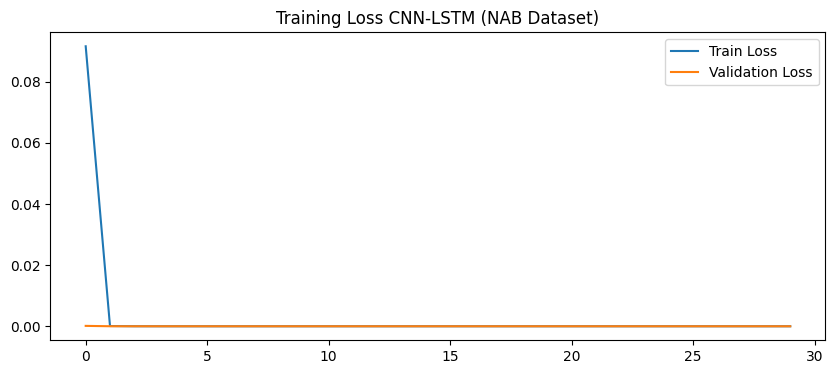

In [14]:
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training Loss CNN-LSTM (NAB Dataset)")
plt.show()


**EVALUASI MODEL**

In [15]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_pred_prob))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy : 0.9307479224376731
Precision: 0.0
Recall   : 0.0
F1-score : 0.0
ROC-AUC  : 0.530952380952381

Classification Report:

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1008
           1       0.00      0.00      0.00        75

    accuracy                           0.93      1083
   macro avg       0.47      0.50      0.48      1083
weighted avg       0.87      0.93      0.90      1083



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_

**BASELINE : SUPPORT VECTOR MACHINE**

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_svm = X.reshape(X.shape[0], -1)

X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(
    X_svm, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train_svm, y_train_svm)

y_svm = svm.predict(X_test_svm)

print("SVM Accuracy:", accuracy_score(y_test_svm, y_svm))


SVM Accuracy: 0.9935364727608494


**EXPORT MODEL KE TENSORFLOW LITE**

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()

with open("cnn_lstm_nab.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil diekspor ke TensorFlow Lite")


Saved artifact at '/tmp/tmpfp50dt2g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 50, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134652260317520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652260318864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652260318480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652260318096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652260318288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652260317328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652260317136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652225177168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134652225176400: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model berhasil diekspor ke TensorFlow Lite
